<a href="https://colab.research.google.com/github/steimel60/ML/blob/main/DeepLearning/ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 719 kB 33.3 MB/s 
     |████████████████████████████████| 4.4 MB 47.8 MB/s 
     |████████████████████████████████| 1.2 MB 45.4 MB/s 
     |████████████████████████████████| 362 kB 61.4 MB/s 
     |████████████████████████████████| 212 kB 12.6 MB/s 
     |████████████████████████████████| 140 kB 16.9 MB/s 
     |████████████████████████████████| 101 kB 5.8 MB/s 
     |████████████████████████████████| 1.1 MB 61.5 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 127 kB 52.1 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 60.5 MB/s 
     |████████████████████████████████| 144 kB 70.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

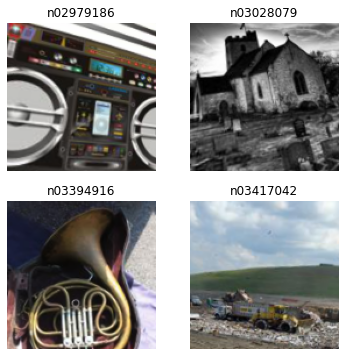

In [2]:
def get_data(url, presize, resize):
  path = untar_data(url)
  return DataBlock(
      blocks=(ImageBlock, CategoryBlock), 
      get_items=get_image_files,
      splitter=GrandparentSplitter(valid_name='val'),
      get_y=parent_label,
      item_tfms=Resize(presize),
      batch_tfms=[*aug_transforms(min_scale=.5, size=resize), Normalize.from_stats(*imagenet_stats)],
  ).dataloaders(path, bs=128)
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

In [3]:
#Make a fully convolutional network
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
  return nn.Sequential(
      block(3,16),
      block(16,32),
      block(32,64),
      block(64,128),
      block(128,256),
      nn.AdaptiveAvgPool2d(1),
      Flatten(),
      nn.Linear(256, dls.c))

SuggestedLRs(valley=0.0003981071640737355)

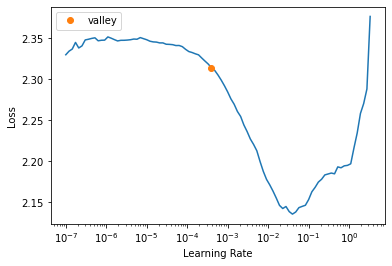

In [4]:
def get_learner(m):
  return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()
learn = get_learner(get_model())
learn.lr_find()

In [5]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.886203,2.170670,0.352611,00:26
1,1.543185,1.657872,0.504713,00:26
2,1.294277,1.393784,0.562803,00:27
3,1.145900,1.138665,0.642548,00:26
4,1.044950,1.066740,0.661147,00:27


In [6]:
def _conv_block(ni,nf,stride):
  return nn.Sequential(
      ConvLayer(ni,nf,stride=stride),
      ConvLayer(nf,nf, act_cls=None, norm_type=NormType.BatchZero)
  )

class ResBlock(Module):
  def __init__(self, ni, nf, stride=1):
    self.convs = _conv_block(ni, nf, stride)
    self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

  def forward(self, x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [7]:
#replace block with resblock
def block(ni, nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.949467,1.818285,0.394140,00:27
1,1.679385,1.639265,0.481783,00:27
2,1.371479,1.206494,0.615796,00:27
3,1.144229,1.087732,0.659618,00:27
4,1.016642,1.026182,0.677962,00:28


In [8]:
#Let's make model twice as deep
def block(ni,nf):
  return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf,nf))
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.941335,1.837329,0.359236,00:36
1,1.616086,1.597306,0.475924,00:35
2,1.331313,1.257347,0.597707,00:30
3,1.103480,1.023969,0.674904,00:35
4,0.960393,0.958229,0.694268,00:34


In [9]:
def _resnet_stem(*sizes):
  return [
          ConvLayer(sizes[i], sizes[i+1], 3, stride=2 if i==0 else 1)
          for i in range(len(sizes)-1)
  ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

class ResNet(nn.Sequential):
  def __init__(self, n_out, layers, expansion=1):
    stem = _resnet_stem(3,32,32,64)
    self.block_szs = [64,64,128,256,512]
    for i in range(1,5): self.block_szs[i] *= expansion
    blocks = [self._make_layer(*o) for o in enumerate(layers)]
    super().__init__(*stem, *blocks, nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(self.block_szs[-1], n_out))

  def _make_layer(self, idx, n_layers):
    stride=1 if idx==0 else 2
    ch_in, ch_out = self.block_szs[idx:idx+2]
    return nn.Sequential(*[
                           ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
                           for i in range(n_layers)
    ])

rn = ResNet(dls.c, [2,2,2,2])

In [10]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.698786,3.507725,0.290701,00:28
1,1.329714,1.836393,0.487898,00:29
2,1.067963,1.025447,0.679490,00:28
3,0.878854,0.956482,0.690191,00:29
4,0.749737,0.769659,0.758726,00:28
